In [6]:
import numpy as np
from classes import Group, Environment, PredictiveModel, DecisionModel
import tqdm
import fico
import distribution_to_loans_outcomes as dlo
import pandas as pd
import time
import loan_lending_experiment
import loan_lending_fairness_metric
import pickle
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.getcwd() + '/../')
import vanilla_monte_carlo

In [7]:
potential_fairness_requirements = [0.3]
potential_sample_rate_mean = [0.05]
potential_sample_rate_std = [0.01]
potential_score_change_repay = [8, 12, 16, 20]
potential_score_change_default = [-16, -24, -32, -40]
potential_score_update_mode = ['equal', 'small_var', 'large_var']
potential_agent = ['eqopp', 'maxprof']
potential_utility_default = list(range(-10, -2))

# get all possible combinations of parameters
all_params = [potential_fairness_requirements, 
                potential_sample_rate_mean, 
                potential_sample_rate_std, 
                potential_score_change_repay, 
                potential_score_change_default,
                potential_utility_default,
                potential_score_update_mode,
                potential_agent]
all_params = np.array(np.meshgrid(*all_params)).T.reshape(-1,len(all_params))

In [8]:
len(all_params)

768

In [9]:
# load results from previous saved pickle
import pickle
with open('./simulation_results/results768_w_utility.pkl', 'rb') as f:
    results = pickle.load(f)

(0.25, 0.35)

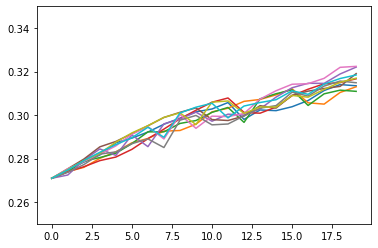

In [12]:
traces = results[254][1][2]
for i in traces:
    plt.plot(i.unfairness_list)
plt.ylim(0.25, 0.35)

(0.25, 0.35)

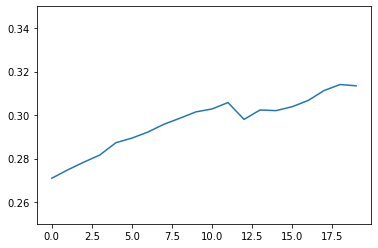

In [13]:
traces = results[254][1][2]
plt.plot(traces[0].unfairness_list)
plt.ylim(0.25, 0.35)

In [ ]:
df_all_params = pd.DataFrame(columns=['score_change_repay', 'score_change_default', 'utility_default', 'potential_score_update_mode', 
                                'agent'], data=all_params[:, 3:8])
df_all_params['avg_max_unfairness_dp'] = 0.0
df_all_params['avg_mean_unfairness_dp'] = 0.0
df_all_params['initial_unfairness_dp'] = 0.0
df_all_params['avg_max_unfairness_cs'] = 0.0
df_all_params['avg_mean_unfairness_cs'] = 0.0
df_all_params['initial_unfairness_cs'] = 0.0
df_all_params['avg_total_utility'] = 0.0
df_all_params['n_traces'] = 0


# get the unfairness score and utility for each configuration
for i in range(len(results)):
    # get unfairness score for DemoParity
    max_unfairness_list = []
    mean_unfairness_list = []
    initial_unfairness_list = []
    for his in results[i][1][2]:
        max_unfairness_list.append(np.max(his.unfairness_list))
        mean_unfairness_list.append(np.mean(his.unfairness_list))
        initial_unfairness_list.append(his.unfairness_list[0])
    df_all_params['avg_max_unfairness_dp'][i] = np.mean(max_unfairness_list)
    df_all_params['avg_mean_unfairness_dp'][i] = np.mean(mean_unfairness_list)
    df_all_params['initial_unfairness_dp'][i] = np.mean(initial_unfairness_list)

    # get unfairness score for credit score
    max_unfairness_list_cs = []
    mean_unfairness_list_cs = []
    initial_unfairness_list_cs = []
    for his in results[i][1][2]:
        credit_score_gap = np.absolute(np.array(his.avg_scores)[:, 0] - np.array(his.avg_scores)[:, 1])
        max_unfairness_list_cs.append(np.max(credit_score_gap))
        mean_unfairness_list_cs.append(np.mean(credit_score_gap))
        initial_unfairness_list_cs.append(credit_score_gap[0])
    df_all_params['avg_max_unfairness_cs'][i] = np.mean(max_unfairness_list_cs)
    df_all_params['avg_mean_unfairness_cs'][i] = np.mean(mean_unfairness_list_cs)
    df_all_params['initial_unfairness_cs'][i] = np.mean(initial_unfairness_list_cs)

    # get utility
    utility_list = []
    for his in results[i][1][2]:
        utility_list.append(np.sum(his.utility_list))
    df_all_params['avg_total_utility'][i] = np.mean(utility_list)

    # check if all values in initial_unfairness_list are the same
    # if not, then there is a problem
    if not all(x == initial_unfairness_list[0] for x in initial_unfairness_list):
        print('error')
    # print(np.mean(max_unfairness_list))
    # df_all_params['avg_unfairness'][i] = np.mean(max_unfairness_list)
    n_traces = results[i][1][1]
    n_violated = results[i][1][3]
    df_all_params['n_traces'][i] = n_traces 


In [15]:
df_all_params

,score_change_repay,score_change_default,utility_default,potential_score_update_mode,agent,avg_max_unfairness_dp,avg_mean_unfairness_dp,initial_unfairness_dp,avg_max_unfairness_cs,avg_mean_unfairness_cs,initial_unfairness_cs,avg_total_utility,n_traces
0,8,-16,-10,equal,eqopp,0.253580,0.245492,0.241693,30.307973,29.437258,28.470233,47886.000000,7
1,12,-16,-10,equal,eqopp,0.252530,0.245727,0.241693,30.684186,29.723164,28.470233,49330.571429,7
2,16,-16,-10,equal,eqopp,0.251485,0.245390,0.241693,30.780589,29.800177,28.470233,49560.500000,8
3,20,-16,-10,equal,eqopp,0.251659,0.245605,0.241693,30.685030,29.791503,28.470233,48328.142857,7
4,8,-24,-10,equal,eqopp,0.256012,0.247783,0.241693,30.496072,29.554804,28.470233,46941.000000,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
763,20,-32,-3,large_var,maxprof,0.502217,0.498080,0.502217,34.004905,31.407698,28.470233,78248.200000,10
764,8,-40,-3,large_var,maxprof,0.502257,0.497372,0.502217,31.106132,29.823933,28.470233,74948.000000,10
765,12,-40,-3,large_var,maxprof,0.502224,0.497386,0.502217,32.177899,30.395440,28.470233,76065.300000,10
766,16,-40,-3,large_var,maxprof,0.502217,0.497534,0.502217,33.194418,30.961414,28.470233,78012.200000,10


In [16]:
df_all_params.shape

(768, 13)

In [12]:
df_all_params.to_csv('./simulation_results/all_params_w_utility768.csv')